In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv('data/final_data.csv')
dataset

,text,labels,id,author,subreddit,created_utc,cluster,topic
0,My favourite food is anything I didn't have to...,27,eebbqej,Rockzilla78,KitchenConfidential,2019-01-18,1,other
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,cocaineluna,morbidquestions,2019-01-01,0,humor
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,minnesotagoat_,timberwolves,2019-01-26,2,sport
3,To make her feel threatened,14,ed7ypvh,AlexNic1013,askwomenadvice,2019-01-04,4,love and relationship
4,Dirty Southern Wankers,3,ed0bdzj,having_a_nap,london,2019-01-01,1,other
...,...,...,...,...,...,...,...,...
54258,Thanks. I was diagnosed with BP 1 after the ho...,15,efeeasc,scaredyk4t,bipolar,2019-01-30,4,love and relationship
54259,Well that makes sense.,4,ef9c7s3,LX_Emergency,ABoringDystopia,2019-01-29,3,politics
54260,Daddy issues [NAME],27,efbiugo,your_ex_girlfriend-,SquaredCircle,2019-01-30,5,film and TV series
54261,So glad I discovered that subreddit a couple m...,0,efbvgp9,Paladin-Arda,AskALiberal,2019-01-30,3,politics


In [3]:
import torch

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


### Train-Validation-Test split

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X = dataset.drop(columns=['labels'])
y = dataset['labels']

# split train - test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split train - validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42) 

In [7]:
# lenght training set
len(X_train)

39069

In [8]:
# lenght validation set
len(X_val)

4341

In [9]:
# lenght testing set
len(X_test)

10853

### Tokenization

In [10]:
from transformers import AutoTokenizer

/home/biso/Uni/corsi/uni_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
model_name = "monologg/bert-base-cased-goemotions-original"

tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(
    list(X_train['text']),
    truncation=True,
    padding=True,
    return_tensors='pt'
)

val_encodings = tokenizer(
    list(X_val['text']),
    truncation=True,
    padding=True,
    return_tensors='pt' 
)

test_encodings = tokenizer(
    list(X_test['text']),
    truncation=True,
    padding=True,
    return_tensors='pt'
)

In [12]:
idx = 0

# original
print("Original:", X_train.iloc[idx]['text'])

print("-------------------------------------------")

# token_id and mask
print("Token IDs:", train_encodings['input_ids'][idx][:10])
print("Attention Mask:", train_encodings['attention_mask'][idx][:10])

print("-------------------------------------------")

# show tokens
tokens = tokenizer.convert_ids_to_tokens(train_encodings['input_ids'][idx])
print("Tokenizzati:", tokens[:10])

Original: Chicken. Mailman.
-------------------------------------------
Token IDs: tensor([  101, 18770,   119, 11508,  1399,   119,   102,     0,     0,     0])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0])
-------------------------------------------
Tokenizzati: ['[CLS]', 'Chicken', '.', 'Mail', '##man', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]']


### Model

In [13]:
from transformers import AutoModelForSequenceClassification

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [15]:
import json

print(json.dumps(model.config.to_dict(), indent=4))

{
    "return_dict": true,
    "output_hidden_states": false,
    "output_attentions": false,
    "torchscript": false,
    "torch_dtype": "float32",
    "use_bfloat16": false,
    "tf_legacy_loss": false,
    "pruned_heads": {},
    "tie_word_embeddings": true,
    "chunk_size_feed_forward": 0,
    "is_encoder_decoder": false,
    "is_decoder": false,
    "cross_attention_hidden_size": null,
    "add_cross_attention": false,
    "tie_encoder_decoder": false,
    "max_length": 20,
    "min_length": 0,
    "do_sample": false,
    "early_stopping": false,
    "num_beams": 1,
    "num_beam_groups": 1,
    "diversity_penalty": 0.0,
    "temperature": 1.0,
    "top_k": 50,
    "top_p": 1.0,
    "typical_p": 1.0,
    "repetition_penalty": 1.0,
    "length_penalty": 1.0,
    "no_repeat_ngram_size": 0,
    "encoder_no_repeat_ngram_size": 0,
    "bad_words_ids": null,
    "num_return_sequences": 1,
    "output_scores": false,
    "return_dict_in_generate": false,
    "forced_bos_token_id": null

In [16]:
print("Number of labels:", model.config.num_labels)
print("------------------------------------------")
map_labels = model.config.id2label
for idx in sorted(map_labels.keys()):
    print(f"Index {idx} -> {map_labels[idx]}")

Number of labels: 28
------------------------------------------
Index 0 -> admiration
Index 1 -> amusement
Index 2 -> anger
Index 3 -> annoyance
Index 4 -> approval
Index 5 -> caring
Index 6 -> confusion
Index 7 -> curiosity
Index 8 -> desire
Index 9 -> disappointment
Index 10 -> disapproval
Index 11 -> disgust
Index 12 -> embarrassment
Index 13 -> excitement
Index 14 -> fear
Index 15 -> gratitude
Index 16 -> grief
Index 17 -> joy
Index 18 -> love
Index 19 -> nervousness
Index 20 -> optimism
Index 21 -> pride
Index 22 -> realization
Index 23 -> relief
Index 24 -> remorse
Index 25 -> sadness
Index 26 -> surprise
Index 27 -> neutral


### Training

In [17]:
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score, classification_report
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch 
import os

In [18]:
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = list(labels) 

    def __getitem__(self, index):
        item = {key: value[index] for key, value in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[index])
        return item

    def __len__(self):
        return len(self.labels)

In [19]:
train_dataset = EmotionDataset(train_encodings, y_train)
val_dataset = EmotionDataset(val_encodings, y_val)
test_dataset = EmotionDataset(test_encodings, y_test)

In [20]:
for i in range(3):
    ex = train_dataset[i]
    print(f"\nSample {i}")
    print("Tokens:", tokenizer.convert_ids_to_tokens(ex['input_ids'][:10]))
    print("Label:", ex['labels'].item())


Sample 0
Tokens: ['[CLS]', 'Chicken', '.', 'Mail', '##man', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]']
Label: 27

Sample 1
Tokens: ['[CLS]', 'This', 'is', 'a', 'hi', '##ge', 'step', '!', 'Con', '##gratulations']
Label: 0

Sample 2
Tokens: ['[CLS]', '>', 'Imagine', 'the', '~', '~', 'nightmare', 'of', 'regulation', '~']
Label: 0


In [21]:
save_path = "./best_model"

In [34]:
model.to(device)

train_batch_size = 32
val_batch_size = 64
n_epochs = 3
learning_rate = 2e-5

# dataloader
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size)

optimizer = AdamW(model.parameters(), lr=learning_rate)

best_f1 = 0.0
save_path = "./best_model"
os.makedirs(save_path, exist_ok=True)

for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    print(f"\n Epoch {epoch+1}/{n_epochs}")

    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss/len(train_loader)
    print(f"✅ Training Loss: {avg_train_loss:.4f}")

    # ---validation---
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Validation Accuracy = {accuracy:4f} | F1 score = {f1:4f}")

    if f1 > best_f1:
        best_f1 = f1
        model.save_pretrained(save_path)

tokenizer.save_pretrained(save_path)
print(f"✅ Modello e tokenizer salvati in: {save_path}")


 Epoch 1/3


100%|██████████| 1221/1221 [08:21<00:00,  2.44it/s]


✅ Training Loss: 0.5829
Validation Accuracy = 0.883207 | F1 score = 0.882518

 Epoch 2/3


100%|██████████| 1221/1221 [10:47<00:00,  1.89it/s]  


✅ Training Loss: 0.3619
Validation Accuracy = 0.872610 | F1 score = 0.872843

 Epoch 3/3


100%|██████████| 1221/1221 [07:51<00:00,  2.59it/s]


✅ Training Loss: 0.2225
Validation Accuracy = 0.865238 | F1 score = 0.864789
✅ Modello e tokenizer salvati in: ./best_model


### Testing

In [22]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from collections import Counter 

In [23]:
model = AutoModelForSequenceClassification.from_pretrained(save_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(save_path)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [24]:
test_batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

# test set results
print("\n Test set results:")
print(f"- Accuracy score = {accuracy:4f}")
print(f"- Precision = {precision:4f}")
print(f"- Recall = {recall:4f}")
print(f"- F1 score = {f1:4f}")

print("\nClassification report:\n")
print(classification_report(all_labels, all_preds))


 Test set results:
- Accuracy score = 0.871280
- Precision = 0.872160
- Recall = 0.871280
- F1 score = 0.870530

Classification report:

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1066
           1       0.92      0.95      0.93       516
           2       0.87      0.85      0.86       405
           3       0.85      0.77      0.81       560
           4       0.87      0.80      0.83       684
           5       0.80      0.77      0.79       233
           6       0.81      0.84      0.82       283
           7       0.82      0.88      0.85       423
           8       0.91      0.73      0.81       144
           9       0.81      0.77      0.79       260
          10       0.84      0.79      0.82       432
          11       0.75      0.88      0.81       152
          12       0.86      0.90      0.88        63
          13       0.72      0.86      0.79       155
          14       0.84      0.86      0.85       1

### Results

In [55]:
len(all_labels)

10853

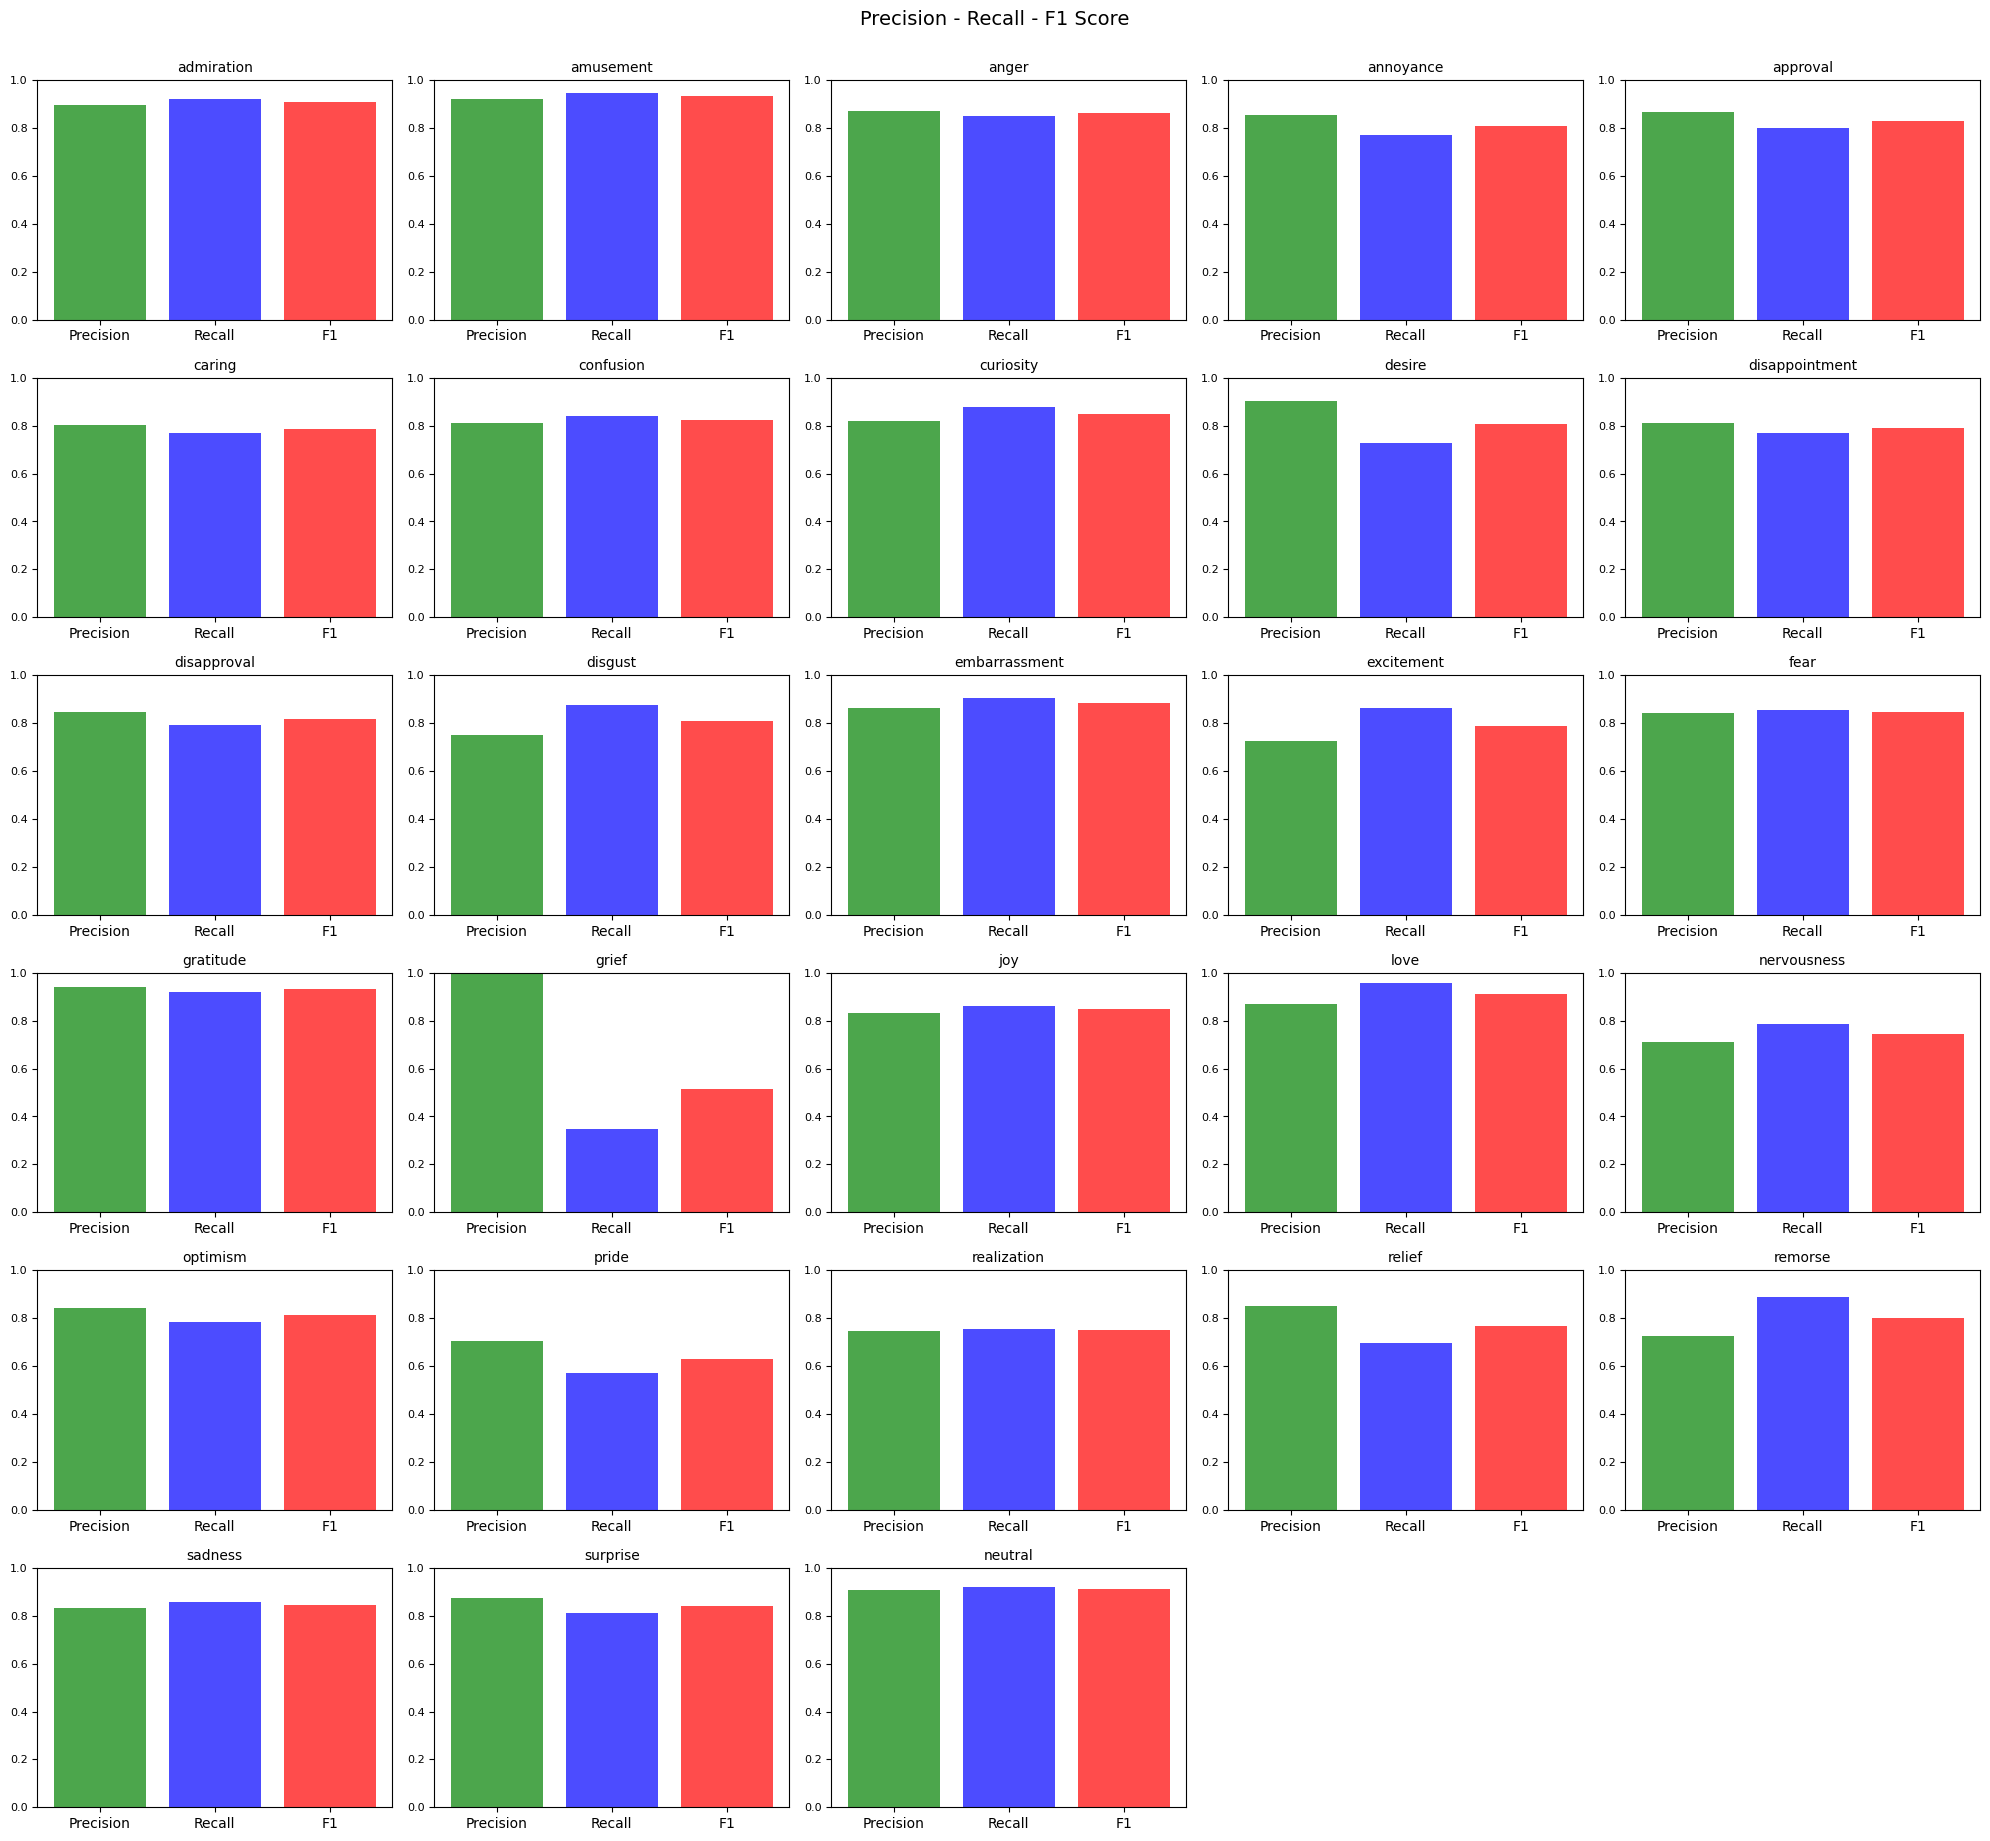

In [25]:
precisions, recalls, f1s, supports = precision_recall_fscore_support(all_labels, all_preds, average=None)

labels = [model.config.id2label[i] for i in range(len(precisions))]

df_metrics = pd.DataFrame({
    'label': labels,
    'precision': precisions,
    'recall': recalls,
    'f1': f1s,
    'support': supports
})

n_labels = len(df_metrics)
cols = 5  
rows = (n_labels + cols - 1) // cols  

fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
axs = axs.flatten()  

colors = ['green', 'blue', 'red']  

for i, row in enumerate(df_metrics.itertuples()):
    ax = axs[i]
    ax.bar(['Precision', 'Recall', 'F1'], [row.precision, row.recall, row.f1], color=colors, alpha=0.7)
    ax.set_ylim(0, 1)
    ax.set_title(row.label, fontsize=10)
    ax.set_xticks([0, 1, 2])
    ax.tick_params(axis='x', rotation=0)
    ax.tick_params(axis='y', labelsize=8)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.suptitle("Precision - Recall - F1 Score", fontsize=14, y=1.02)
plt.show()

In [26]:
df_metrics

,label,precision,recall,f1,support
0,admiration,0.897903,0.924015,0.910772,1066
1,amusement,0.920755,0.945736,0.933078,516
2,anger,0.873418,0.851852,0.862500,405
3,annoyance,0.853465,0.769643,0.809390,560
4,approval,0.866878,0.799708,0.831939,684
5,caring,0.802691,0.768240,0.785088,233
6,confusion,0.809524,0.840989,0.824957,283
7,curiosity,0.820796,0.877069,0.848000,423
8,desire,0.905172,0.729167,0.807692,144
9,disappointment,0.813008,0.769231,0.790514,260


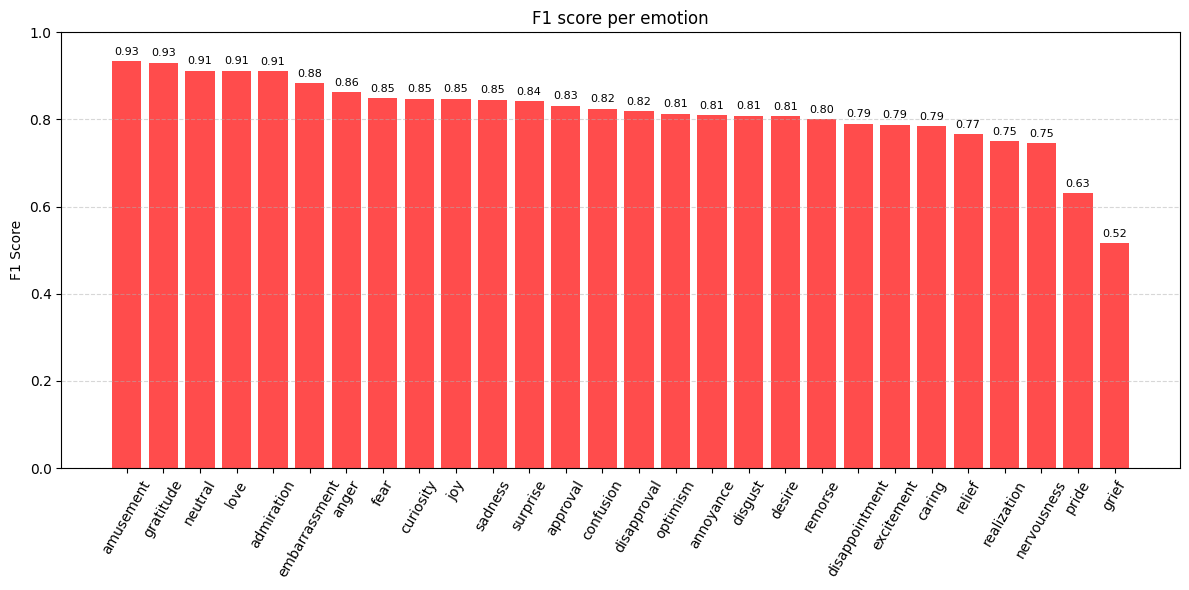

In [27]:
sorted_f1 = df_metrics.sort_values(by='f1', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_f1['label'], sorted_f1['f1'], color='red', alpha=0.7)

plt.xticks(rotation=60, ha='center')
plt.ylabel("F1 Score")
plt.title("F1 score per emotion")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f"{height:.2f}",
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


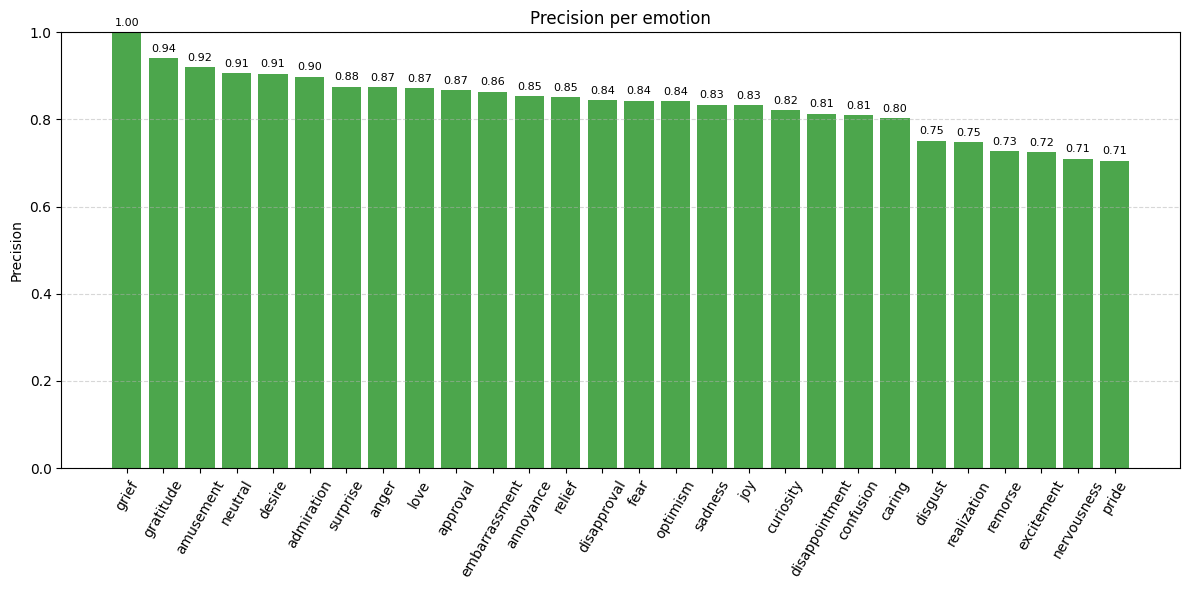

In [ ]:
sorted_precision = df_metrics.sort_values(by='precision', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_precision['label'], sorted_precision['precision'], color='green', alpha=0.7)

plt.xticks(rotation=60, ha='center')
plt.ylabel("Precision")
plt.title("Precision per emotion")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f"{height:.2f}",
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

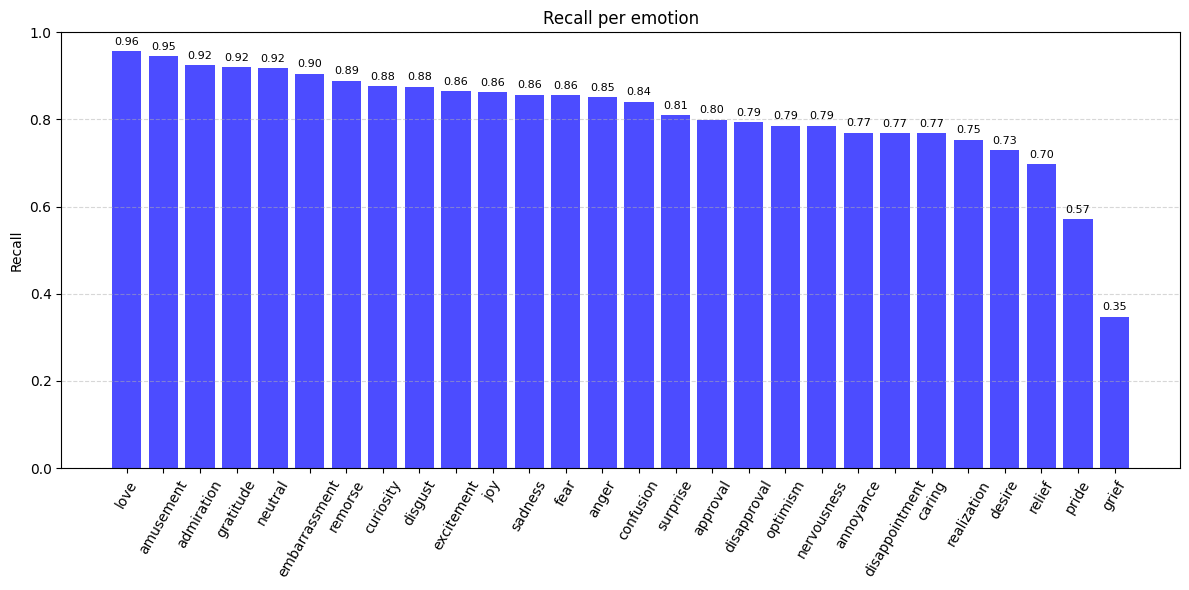

In [29]:
sorted_recall = df_metrics.sort_values(by='recall', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_recall['label'], sorted_recall['recall'], color='blue', alpha=0.7)

plt.xticks(rotation=60, ha='center')
plt.ylabel("Recall")
plt.title("Recall per emotion")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f"{height:.2f}",
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


           Emotion  Support
0          neutral    11560
1       admiration     3635
2         approval     2349
3        amusement     2055
4        gratitude     1941
5        annoyance     1908
6        curiosity     1601
7      disapproval     1510
8            anger     1361
9             love     1339
10       confusion     1124
11  disappointment      932
12             joy      905
13        optimism      882
14          caring      870
15         sadness      765
16     realization      680
17        surprise      670
18      excitement      630
19         disgust      520
20          desire      494
21            fear      471
22         remorse      379
23   embarrassment      220
24     nervousness       96
25          relief       69
26           grief       55
27           pride       48


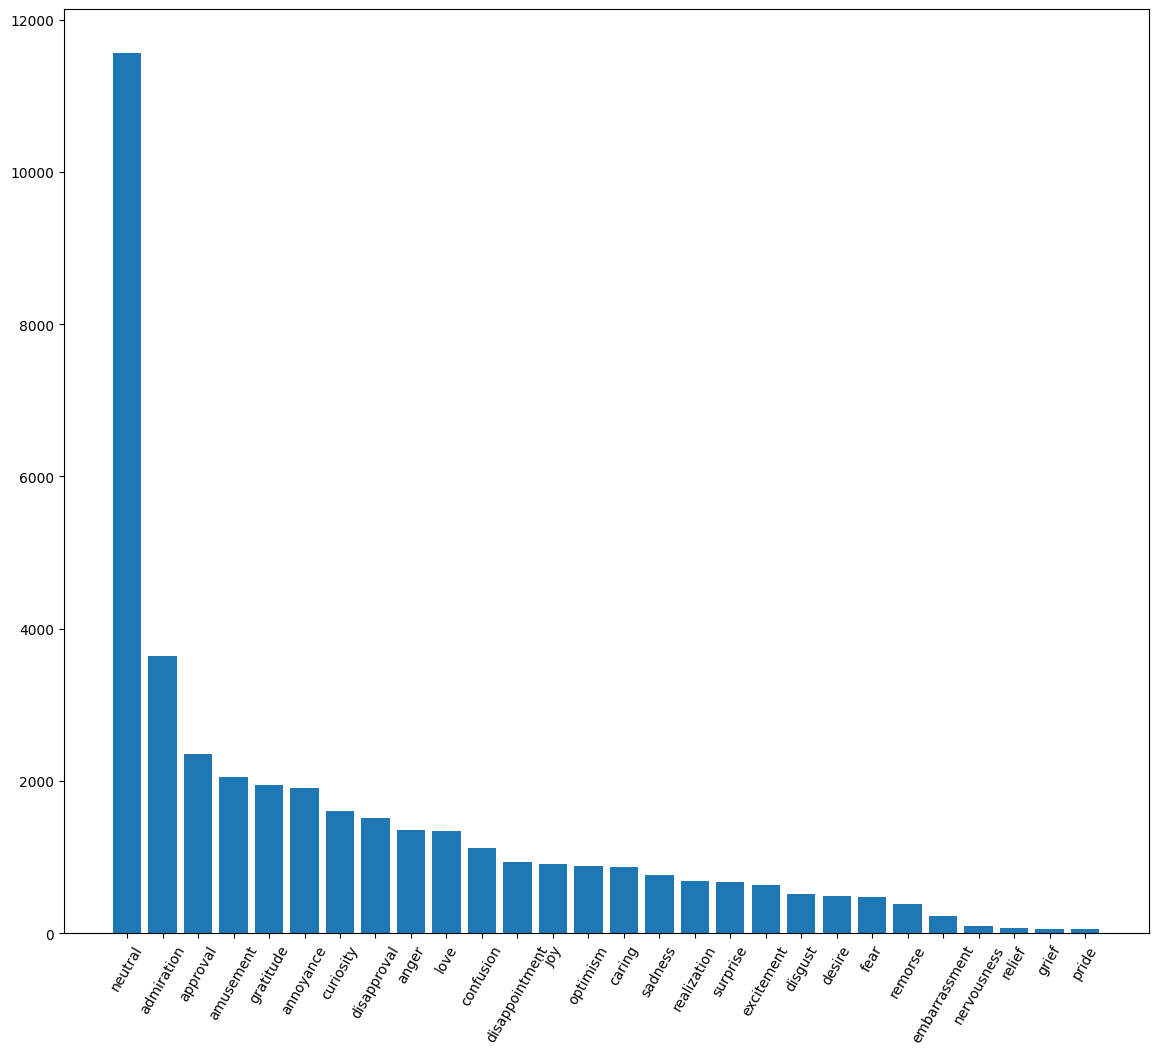

In [30]:
# train support
train_counts = Counter(y_train)

df_train_support = pd.DataFrame([
    {'Emotion': model.config.id2label[label], 'Support': count} for label, count in train_counts.items()
])

df_train_support = df_train_support.sort_values(by='Support', ascending=False).reset_index(drop=True)

print(df_train_support)

plt.figure(figsize=(14, 12))
plt.bar(df_train_support['Emotion'], df_train_support['Support'])
plt.xticks(rotation=60, ha='center')
plt.show()

/tmp/ipykernel_1947/320753596.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['label'], rotation=60, ha='center')


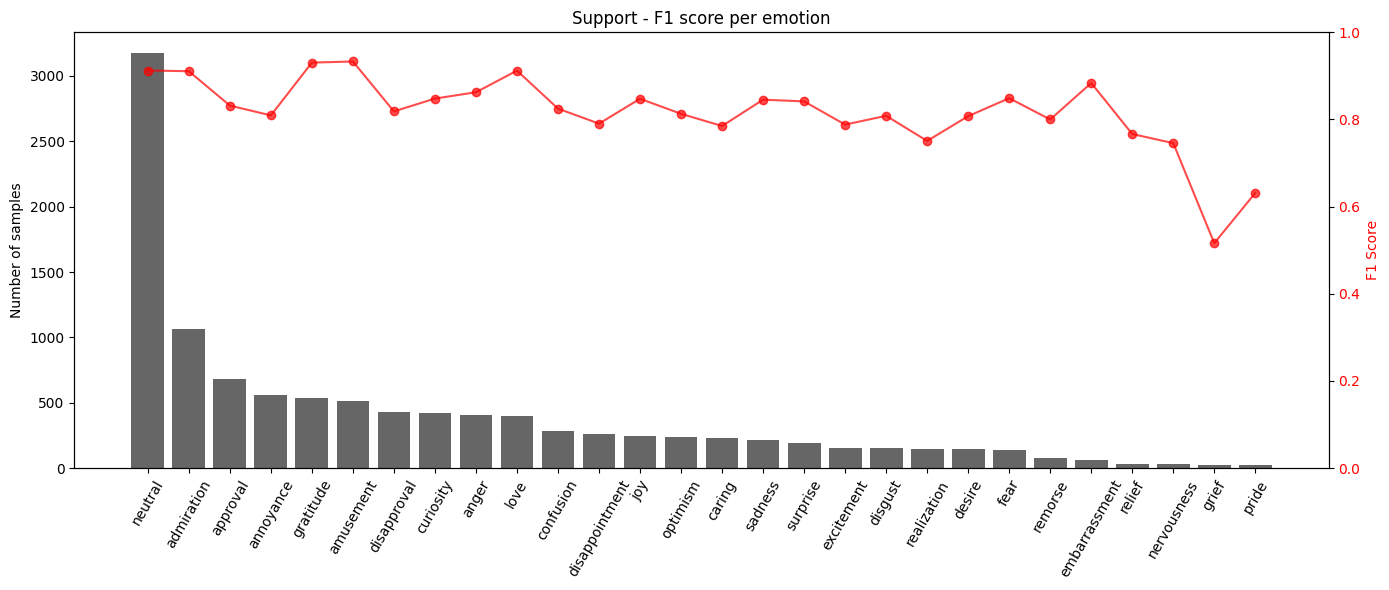

In [31]:
df = df_metrics.sort_values(by='support', ascending=False)

fig, ax1 = plt.subplots(figsize=(14, 6))

color_support = 'black'
ax1.bar(df['label'], df['support'], color=color_support, label='Support (test)', alpha=0.6)
ax1.set_ylabel('Number of samples', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticklabels(df['label'], rotation=60, ha='center')

ax2 = ax1.twinx()
ax2.plot(df['label'], df['f1'], color='red', marker='o', label='F1 Score', alpha=0.7)
ax2.set_ylabel('F1 Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 1)

plt.title("Support - F1 score per emotion")
fig.tight_layout()
plt.show()

/tmp/ipykernel_1947/249255234.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['label'], rotation=60, ha='center')


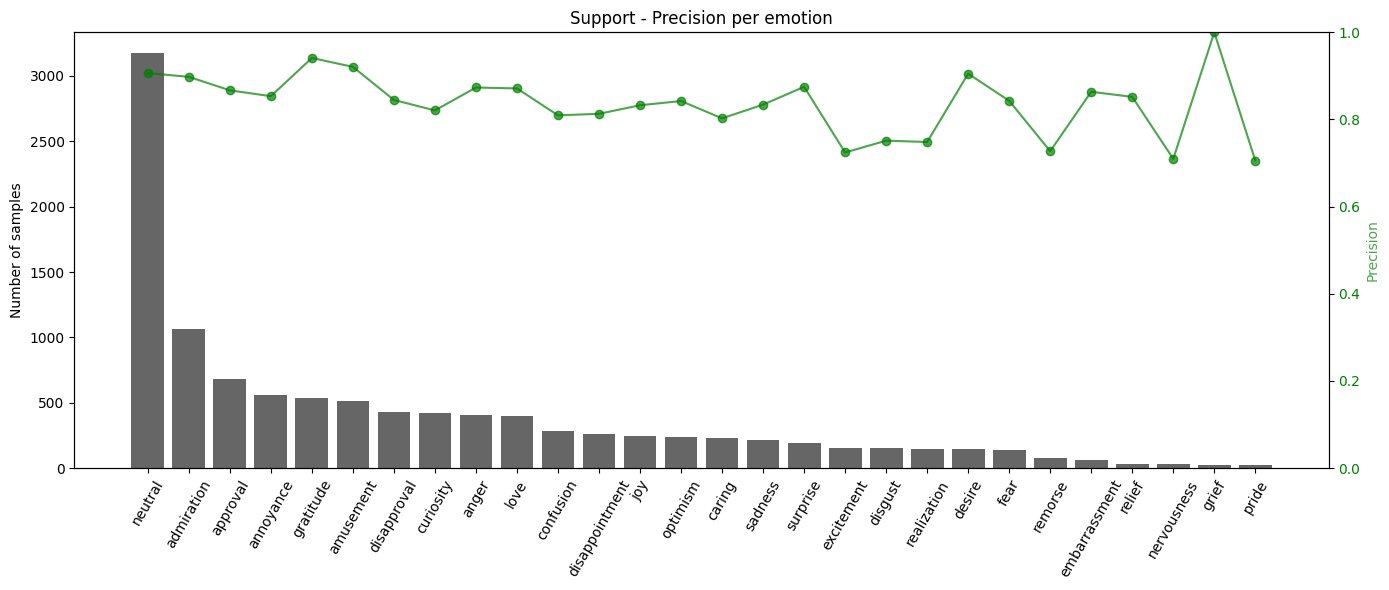

In [32]:
fig, ax1 = plt.subplots(figsize=(14, 6))

color_support = 'black'
ax1.bar(df['label'], df['support'], color=color_support, label='Support (test)', alpha=0.6)
ax1.set_ylabel('Number of samples', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticklabels(df['label'], rotation=60, ha='center')

ax2 = ax1.twinx()
ax2.plot(df['label'], df['precision'], color='green', marker='o', label='Precision', alpha=0.7)
ax2.set_ylabel('Precision', color='green', alpha=0.7)
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylim(0, 1)

plt.title("Support - Precision per emotion")
fig.tight_layout()
plt.show()

/tmp/ipykernel_1947/2580630151.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['label'], rotation=60, ha='center')


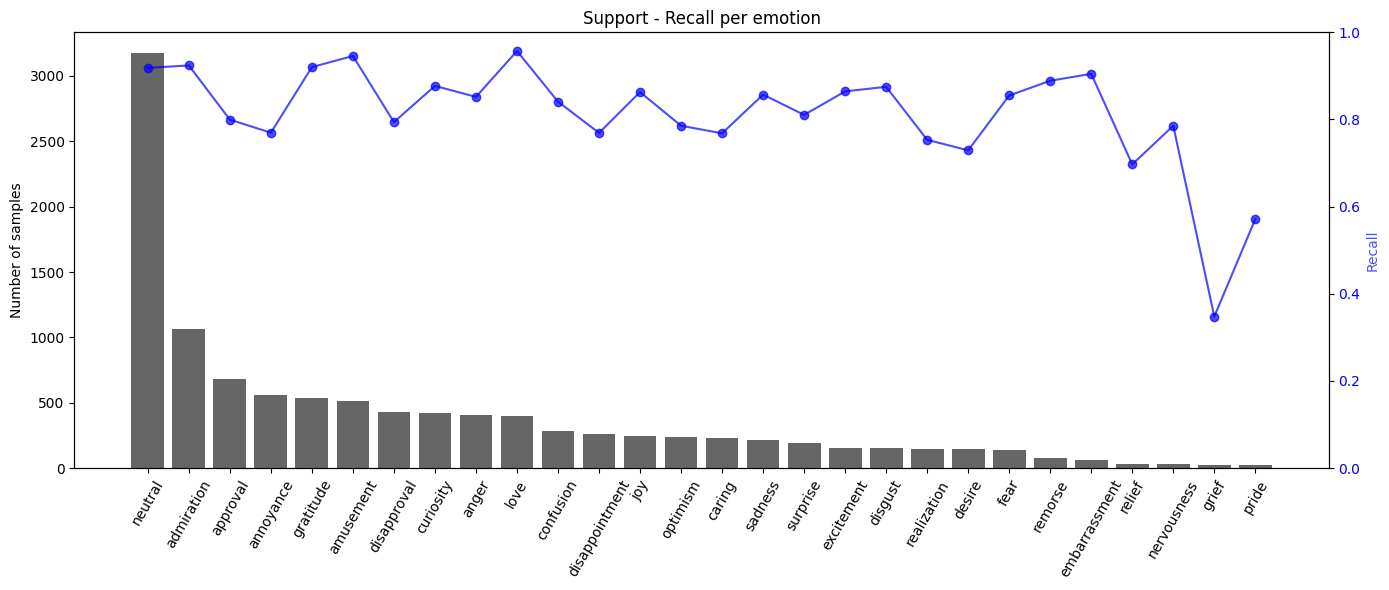

In [33]:
fig, ax1 = plt.subplots(figsize=(14, 6))

color_support = 'black'
ax1.bar(df['label'], df['support'], color=color_support, label='Support (test)', alpha=0.6)
ax1.set_ylabel('Number of samples', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticklabels(df['label'], rotation=60, ha='center')

ax2 = ax1.twinx()
ax2.plot(df['label'], df['recall'], color='blue', marker='o', label='Recall', alpha=0.7)
ax2.set_ylabel('Recall', color='blue', alpha=0.7)
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(0, 1)

plt.title("Support - Recall per emotion")
fig.tight_layout()
plt.show()

In [34]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [35]:
print(model.classifier)
print(model.classifier.weight.shape)

Linear(in_features=768, out_features=28, bias=True)
torch.Size([28, 768])


### Compare multiple texts

In [ ]:
def compare_multiple_emotions(model, X_test, all_probs, indices):

    n = len(indices)
    fig, axs = plt.subplots(1, n, figsize=(5*n, 5))

    for ax, idx in zip(axs, indices):
        text = X_test.iloc[idx]['text']
        probs = all_probs[idx]
        sorted_indices = np.argsort(probs)[::-1][:10]
        labels = [model.config.id2label[i] for i in sorted_indices]
        values = [probs[i] for i in sorted_indices]

        ax.barh(labels[::-1], values[::-1])
        ax.set_xlim(0, 1)
        ax.set_title(f"Top 10 predicted emotions - \"{text}\"", fontsize=10)
        ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.show()

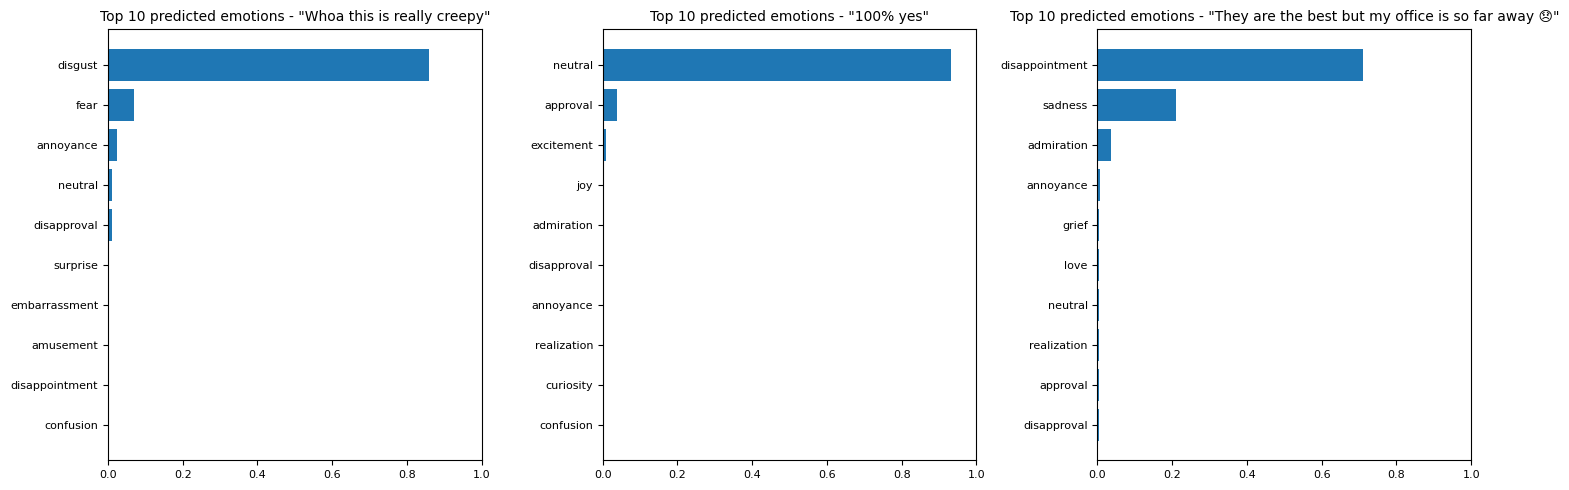

In [37]:
compare_multiple_emotions(model, X_test, all_probs, indices=[0, 5, 20])

### New examples

In [38]:
def predict_emotions(text, model, tokenizer, top_k=5):
    # tokenization
    inputs = tokenizer(text, 
                       return_tensors='pt',
                       truncation=True,
                       padding=True).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1).squeeze()

    # get top k emotions
    top_indices = torch.topk(probs, k=top_k).indices.tolist()
    top_labels = [model.config.id2label[i] for i in top_indices]
    top_probs = [probs[i].item() for i in top_indices]

    plt.figure(figsize=(8, 4))
    bars = plt.barh(top_labels[::-1], top_probs[::-1], color='orange', alpha=0.7)
    plt.xlabel("Probability")
    plt.title("Top Emotions Predicted")
    plt.xlim(0, 1)

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2,
                 f"{width:.4f}", va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

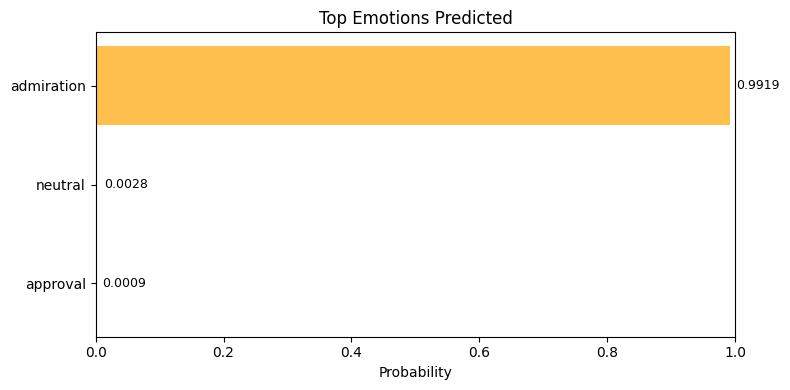

In [39]:
predict_emotions("Your dedication to the project is truly inspiring.", model, tokenizer, 3)

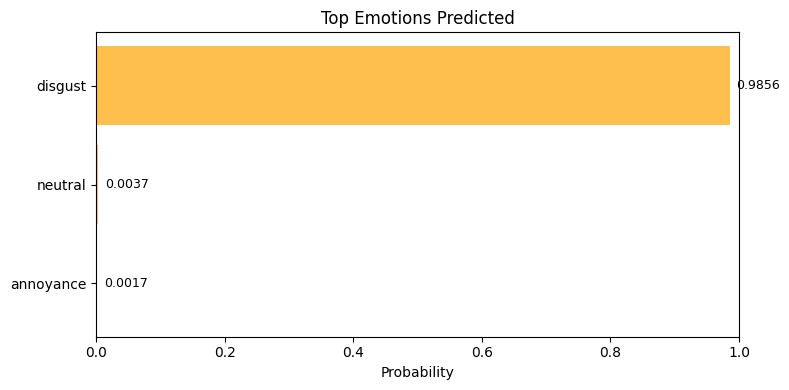

In [40]:
# disgust
predict_emotions("He sneezed into his food and just kept eating. Absolutely disgusting.", model, tokenizer, 3)

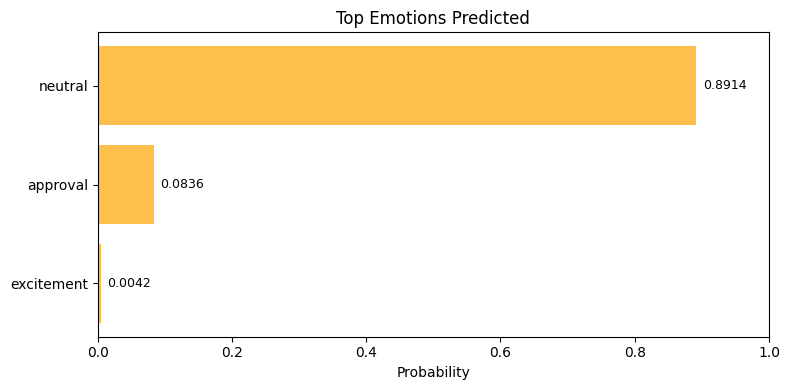

In [41]:
# neutral
predict_emotions("The meeting is scheduled for 3 PM.", model, tokenizer, 3)

Try on label with few examples:
+ pride
+ grief
+ relief
+ nervousness

Examples generated with ChatGPT

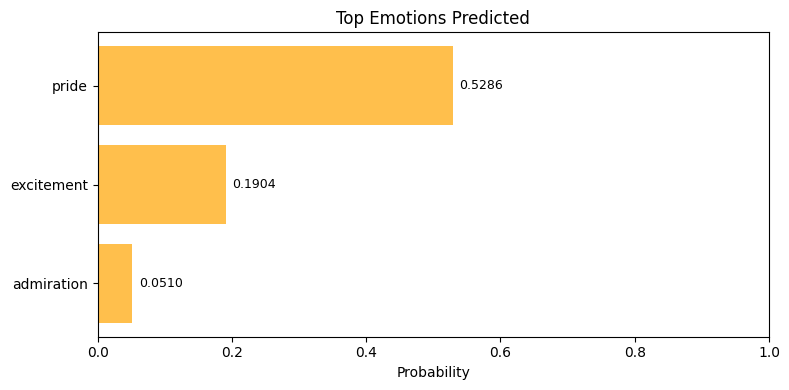

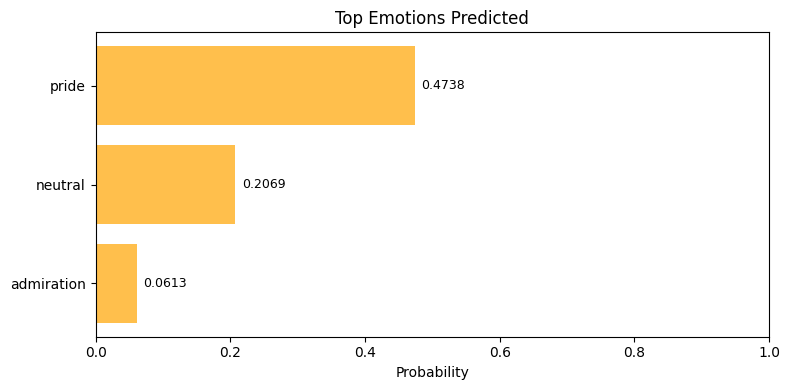

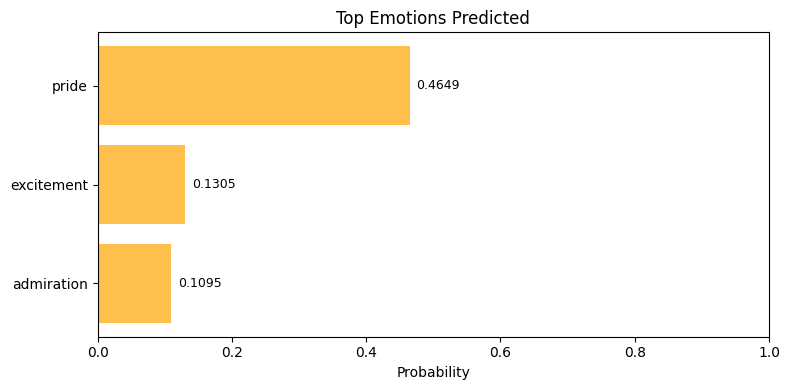

In [42]:
# pride
pride = [
    "Just landed my first job after months of grinding. Honestly, I’ve never felt prouder.",
    "Fixed the leaky sink all by myself—no plumber, no YouTube tutorial, just me. Kinda proud ngl.",
    "Taught my little brother how to ride a bike today. He was scared at first, but now he’s flying. Big bro moment of pride."
]

for t in pride:
    predict_emotions(t, model, tokenizer, 3)

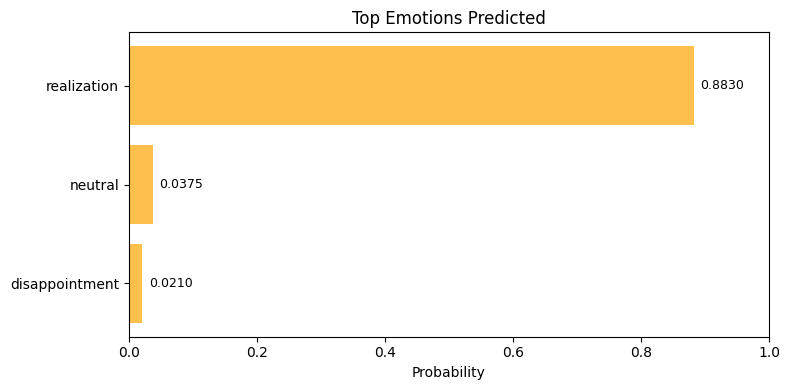

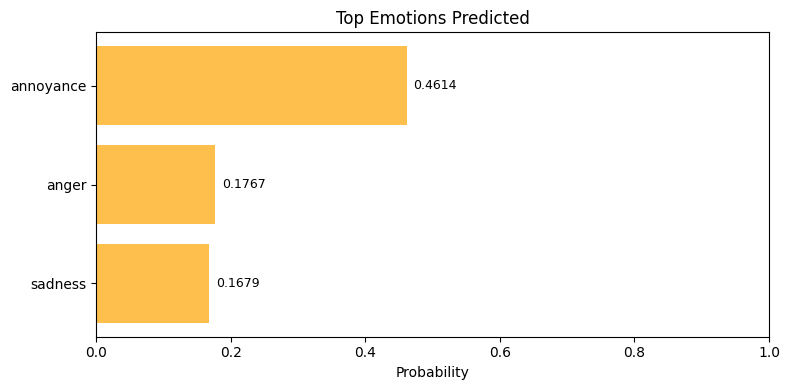

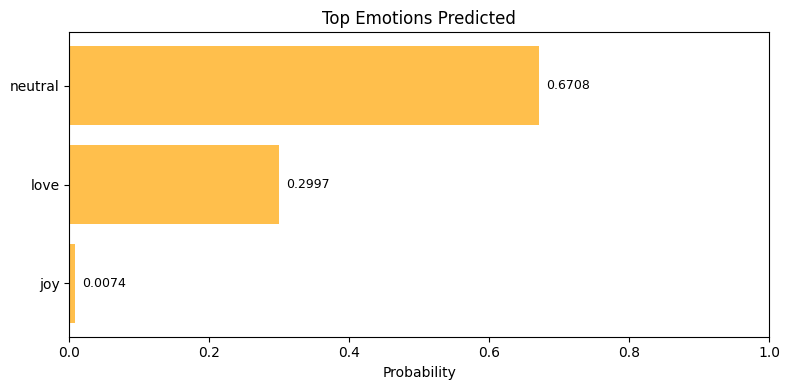

In [43]:
# grief
grief = [
    "my phone lights up and for a split second i think it's her—then it hits me all over again.",
    "laid my dad to rest yesterday; the silence in the house is unbearable.",
    "boxed up his favorite games today and every click of the tape felt like saying goodbye twice."
]

for t in grief:
    predict_emotions(t, model, tokenizer, 3)

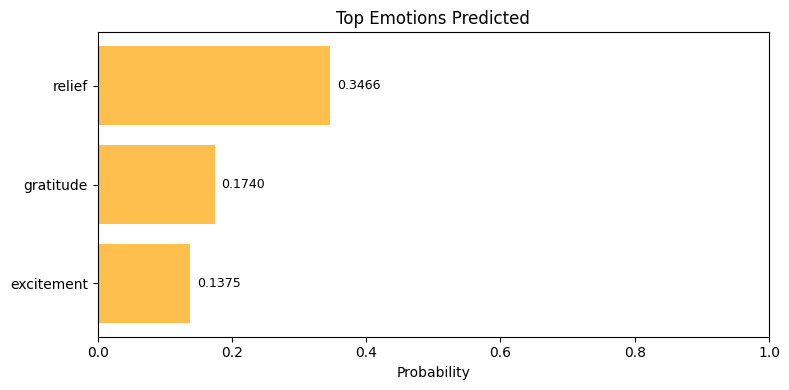

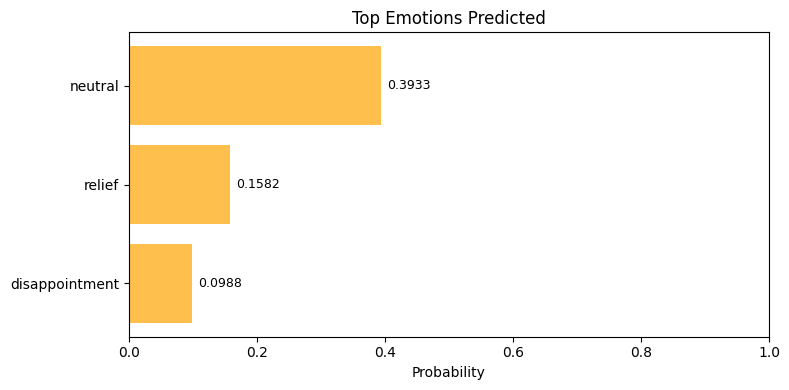

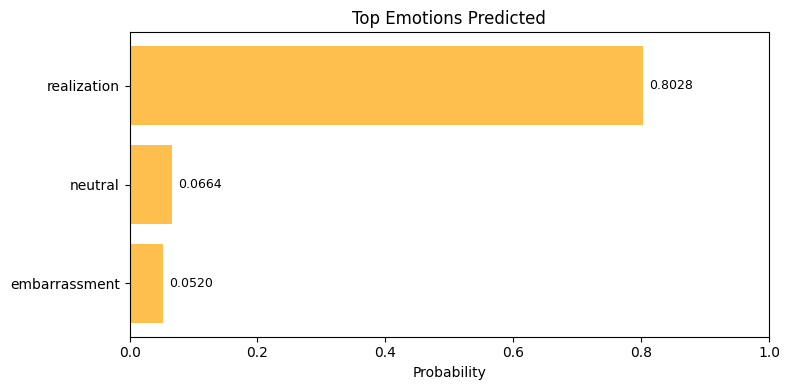

In [44]:
# relief
relief = [
    "phew, that's finally over and done with.",
    "test came back negative—i can breathe again!",
    "thought i lost my wallet but it was just under the car seat."
]

for t in relief:
    predict_emotions(t, model, tokenizer, 3)

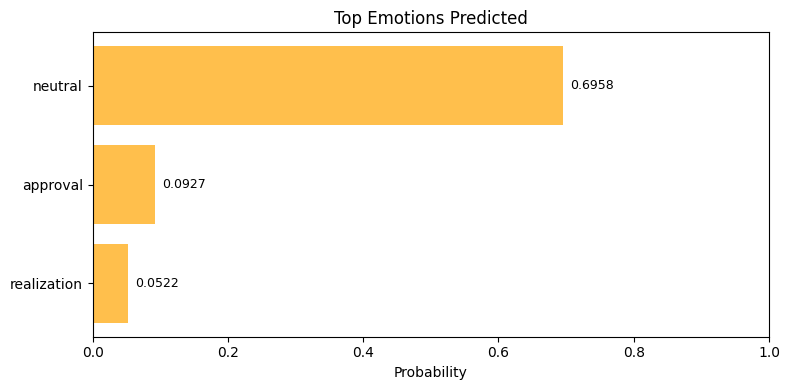

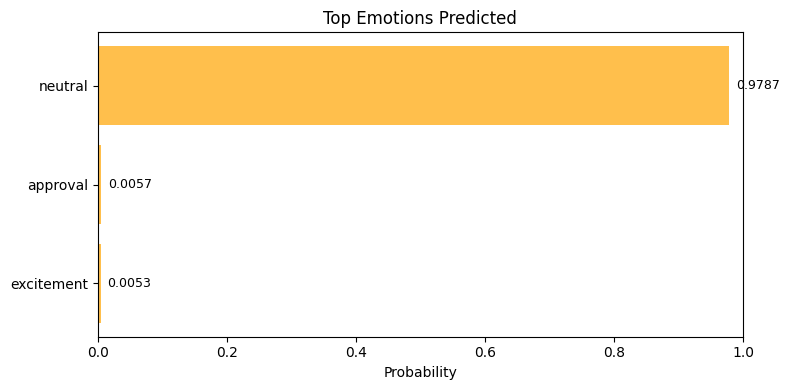

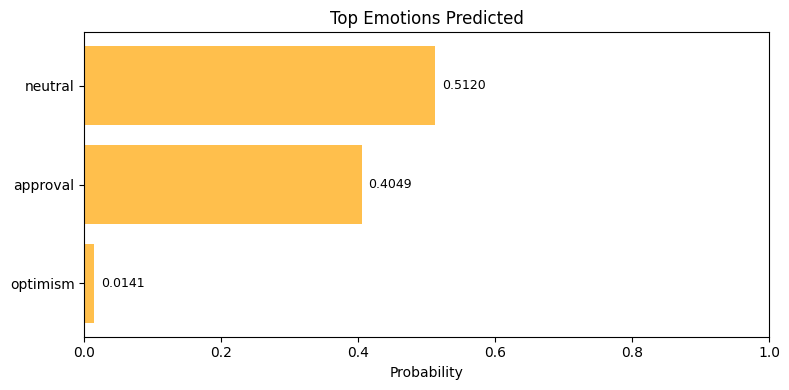

In [45]:
# nervousness
nervousness = [
    "Got a big presentation in the morning and I keep rewriting my intro. My stomach’s in knots.",
    "Meeting her parents tonight for the first time. I’ve changed outfits like five times already.",
    "Just sent in my application for the scholarship. Now the waiting begins... fingers crossed."
]

for t in nervousness:
    predict_emotions(t, model, tokenizer, 3)

### True label - Predicted label

In [46]:
n = 10

for i in range(n):
    text = X_test.iloc[i]["text"]
    true_id = y_test.iloc[i]
    pred_id = all_preds[i]

    true_label = model.config.id2label[true_id]
    pred_label = model.config.id2label[pred_id]

    print(f"\nOriginal text: {text}")
    print(f"True emotion: {true_label}")
    print(f"Predicted emotion: {pred_label}")


Original text: Whoa this is really creepy
True emotion: disgust
Predicted emotion: disgust

Original text: Ok, I will take this with a pinch of salt, but take it into consideration nonetheless. Thanks.
True emotion: approval
Predicted emotion: approval

Original text: I love bloodborne, I started my second play through but quit after I got busy with school stuff.. need to go back to it though.. love that game 
True emotion: love
Predicted emotion: love

Original text: Oh my goodness, I'm so glad you were there too. You made his day suck a little less. 
True emotion: joy
Predicted emotion: joy

Original text: Yeah -- a woman who expects a guy to never even think about other women for the rest of his life is a special kind of delusional.
True emotion: admiration
Predicted emotion: admiration

Original text: 100% yes
True emotion: neutral
Predicted emotion: neutral

Original text: People would still always parry them (600ms) :(
True emotion: annoyance
Predicted emotion: disappointment

O

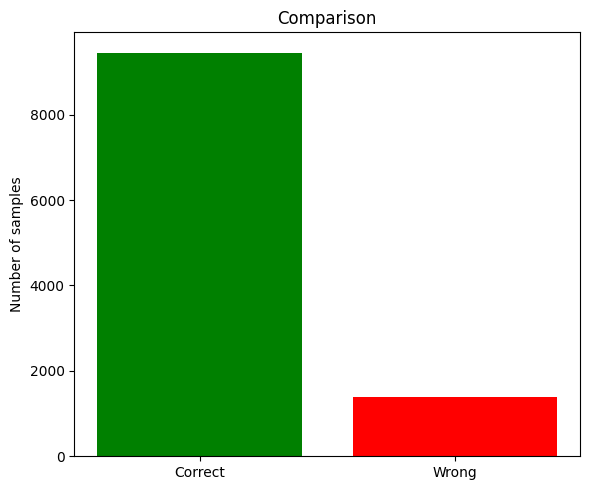

In [47]:
correct = sum(all_preds[i] == y_test.iloc[i] for i in range(len(all_preds)))
wrong = len(all_preds) - correct

# Dati
labels = ['Correct', 'Wrong']
counts = [correct, wrong]
colors = ['green', 'red']

# Plot
plt.figure(figsize=(6, 5))
plt.bar(labels, counts, color=colors)
plt.title("Comparison")
plt.ylabel("Number of samples")
plt.tight_layout()
plt.show()

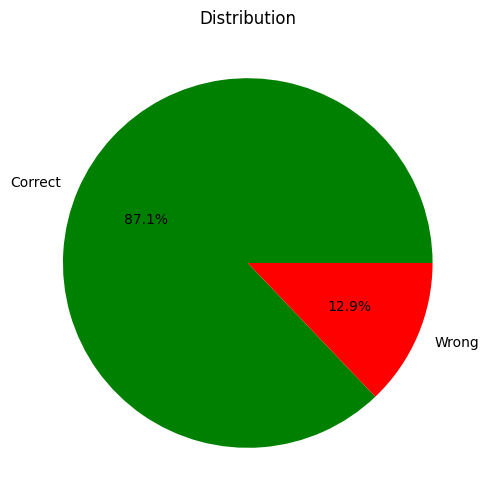

In [48]:
plt.figure(figsize=(6, 6))
plt.pie([correct, wrong], labels=["Correct", "Wrong"], autopct='%1.1f%%', colors=["green", "red"])
plt.title("Distribution")
plt.show()

### Confusion matrix

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import collections

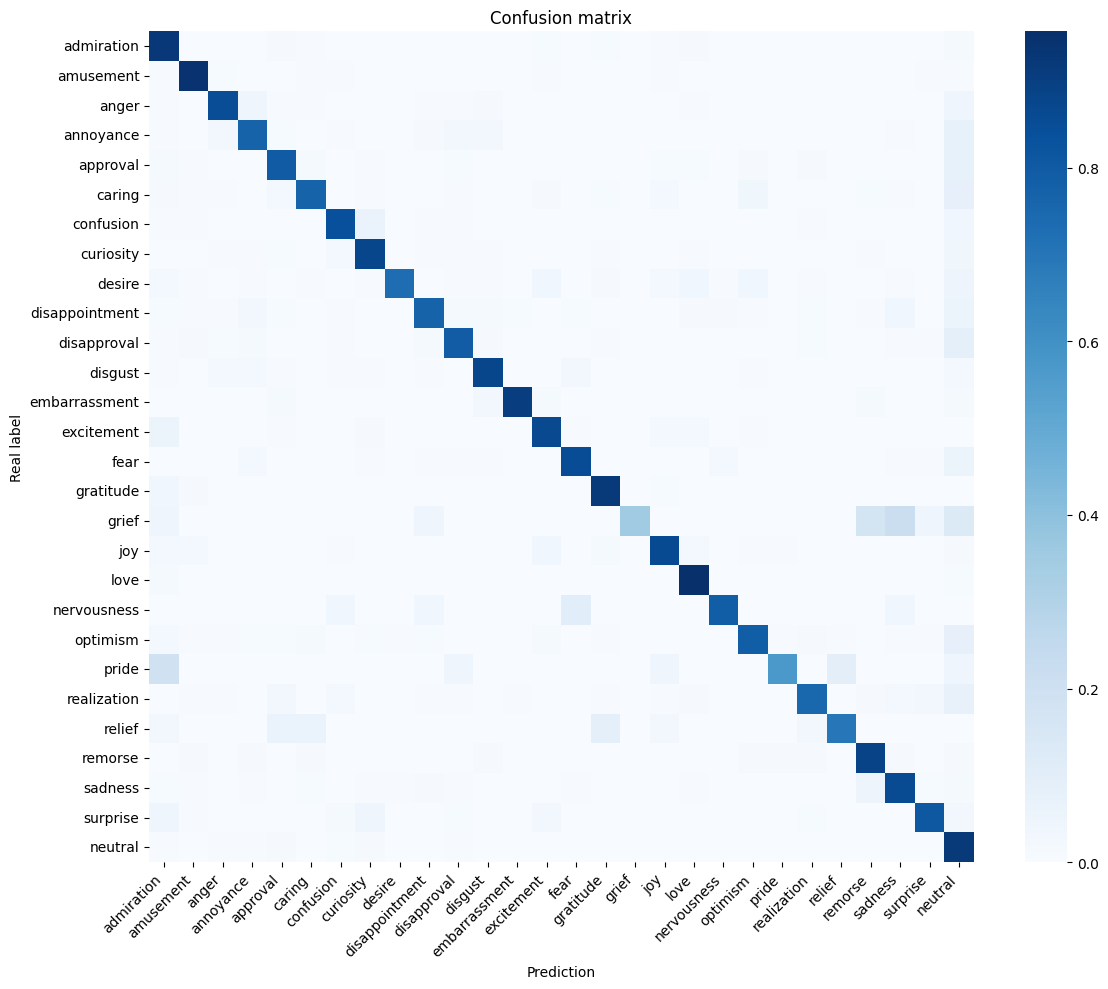

In [50]:
cm = confusion_matrix(y_test, all_preds, normalize='true')
labels = [model.config.id2label[i] for i in range(len(cm))]

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.xlabel("Prediction")
plt.ylabel("Real label")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [51]:
confusions = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i][j] > 0.01:  # ignora valori < 1%
            confusions.append({
                'True Emotion': labels[i],
                'Predicted Emotion': labels[j],
                'Proportion': cm[i][j]
            })

# Ordina per proporzione decrescente
confusions_sorted = sorted(confusions, key=lambda x: x['Proportion'], reverse=True)
top_5_confusions = confusions_sorted[:10]

print(top_5_confusions)

# Stampa risultati
print("Top 5:\n")
for entry in top_5_confusions:
    perc = entry['Proportion'] * 100
    print(f"✅ Real: {entry['True Emotion']:15s} → ❌ Predicted: {entry['Predicted Emotion']:15s} | 🔁 {perc:.2f}%")

[{'True Emotion': 'grief', 'Predicted Emotion': 'sadness', 'Proportion': np.float64(0.21739130434782608)}, {'True Emotion': 'pride', 'Predicted Emotion': 'admiration', 'Proportion': np.float64(0.19047619047619047)}, {'True Emotion': 'grief', 'Predicted Emotion': 'remorse', 'Proportion': np.float64(0.17391304347826086)}, {'True Emotion': 'grief', 'Predicted Emotion': 'neutral', 'Proportion': np.float64(0.13043478260869565)}, {'True Emotion': 'nervousness', 'Predicted Emotion': 'fear', 'Proportion': np.float64(0.10714285714285714)}, {'True Emotion': 'pride', 'Predicted Emotion': 'relief', 'Proportion': np.float64(0.09523809523809523)}, {'True Emotion': 'relief', 'Predicted Emotion': 'gratitude', 'Proportion': np.float64(0.09090909090909091)}, {'True Emotion': 'disapproval', 'Predicted Emotion': 'neutral', 'Proportion': np.float64(0.08796296296296297)}, {'True Emotion': 'caring', 'Predicted Emotion': 'neutral', 'Proportion': np.float64(0.0815450643776824)}, {'True Emotion': 'optimism', 'P

In [52]:
counts = collections.Counter(y_test)
print("Distribution real labels:")
for i, c in counts.items():
    print(f"{model.config.id2label[i]:15s}: {c}")

Distribution real labels:
disgust        : 152
approval       : 684
love           : 396
joy            : 248
admiration     : 1066
neutral        : 3175
annoyance      : 560
amusement      : 516
curiosity      : 423
gratitude      : 539
disappointment : 260
optimism       : 238
excitement     : 155
anger          : 405
confusion      : 283
surprise       : 190
realization    : 150
sadness        : 217
caring         : 233
disapproval    : 432
fear           : 138
nervousness    : 28
desire         : 144
remorse        : 81
grief          : 23
relief         : 33
pride          : 21
embarrassment  : 63


### Predictions